In [1]:
import pandas as pd
import numpy as np
import os
from backtest import *

# 生成股票池
    - 流動性:

In [4]:
adj_price = pd.read_feather('/home/qianshuofu/Yansheng_strategy/data/adj_daily_TWSE_TPEX.ftr')
adj_price = adj_price[adj_price['trade_date']>=pd.to_datetime('20180101')]
adj_price.rename(columns={
    'trade_date': 'datetime'
}, inplace=True)
adj_price = adj_price[['datetime', 'asset', 'amount']]
amount_ma20 = adj_price.set_index(['datetime']).groupby('asset')['amount'].rolling(20).mean().reset_index()

In [7]:
# liquidity: 1000w
liqiuid_cond = 1000 * 10000
amount_ma20 = amount_ma20[amount_ma20['amount']>=liqiuid_cond]
amount_ma20 = amount_ma20.set_index(['datetime', 'asset'])
amount_ma20 = amount_ma20.sort_index()
amount_ma20.columns = ['amount_ma20']

In [9]:
# 1. 流動性條件
asset_pool = amount_ma20

# backtest

In [10]:
ROOT = '/home/qianshuofu/Yansheng_strategy/data'
data = pd.read_pickle(os.path.join(ROOT, 't_plus_max5_first_tradeday_adj_price.pkl'))
industry = pd.read_csv(os.path.join(ROOT, "industry_twse_tpex.csv"))
industry['asset'] = industry['asset'].astype(str)
factors = pd.read_pickle(os.path.join(ROOT, "sample.pkl"))

f = 'mid_sub_small_ratio_share_diff4w'
prediction = factors[f].copy()
prediction.name = 'pred'

## 生成持倉: 

    constraint: 
    - 持倉價位限制 (股票池)
    - 取每周rank排名最前面的一群
    - 排除開盤漲停股票 (不能買進)
    - 取得每周預期持倉張數
    - 在開盤調倉
    - 取得上周持倉預期持倉 (回測用，第一周的上週持倉為0)    
    - 取得下周持倉預期持倉 (回測用，最後一周持倉假設全出, 為0)

In [14]:
# 簡略條件
capital = 500*10000
max_w = 0.04

holdings = get_holdings(prediction=prediction, data=data, industry=industry,
                        asset_pool=asset_pool, capital=capital, max_w=max_w)

# 回測
    交易成本計算方法:
    1. 手續費率: 買進與賣出皆需要收取 (0.001425 * 折數)
    2. 證交稅率: 賣出收取 (0.003) 
    3. 融資費率: 以年利息6%計算 (年息轉換成周息(年息/52)，以6成金額計算融資)
    
    計算交易成本分成三部分:
    1. 新增的倉位 (成本: 手續費率(買進))
    2. 需換倉的倉位 (成本: 手續費率(賣出)+證交稅率+融資費率)
    3. 無須換倉的倉位 (成本: 無，假設新增的倉位與需換倉的倉位才支付買進手續費)

       Market_Value   Gross_Profit    fee_rate      return
count  1.930000e+02     193.000000  193.000000  193.000000
mean   4.095292e+06   34541.607330    0.002066    0.008499
std    2.235028e+05  179436.710024    0.000594    0.043314
min    3.460000e+06 -863329.010332    0.000106   -0.218891
25%    3.971100e+06  -50581.229952    0.001852   -0.012240
50%    4.116850e+06   48957.386351    0.002094    0.011517
75%    4.240400e+06  123592.286785    0.002393    0.031597
max    4.573650e+06  520149.753177    0.004147    0.125900


,單利,複利
年化收益,0.441954,0.477639
累计收益,1.640328,3.259511
最大回撤,0.290084,0.290666
夏普(r=4%),1.290241,1.404789
波动率,0.311534,0.311534
總交易周,193.000000,193.000000
凈獲利交易周,121.000000,121.000000
凈虧損交易周,72.000000,72.000000
勝率,0.626943,0.626943
周均凈收益,0.008499,0.016889


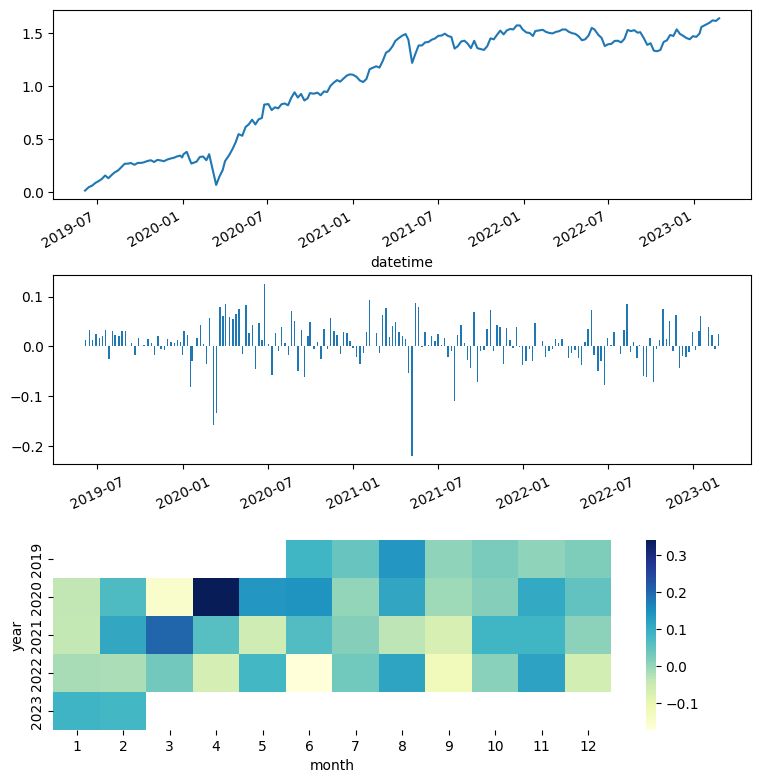

In [17]:
analyze_risk_position_weekly(holdings, show_details=True)
# analyze_risk_position_weekly(holdings)